In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import os
from pathlib import Path

# Définition des chemins du projet 
PROJECT_ROOT = Path("E:/EpiSight")
RAW_DATA = PROJECT_ROOT / "data" / "raw"
PROCESSED_DATA = PROJECT_ROOT / "data" / "processed"

# Création des dossiers s'ils n'existent pas encore
RAW_DATA.mkdir(parents=True, exist_ok=True)
PROCESSED_DATA.mkdir(parents=True, exist_ok=True)

print(f"Dossier raw : {RAW_DATA}")
print(f"Dossier processed : {PROCESSED_DATA}")

Dossier raw : E:\EpiSight\data\raw
Dossier processed : E:\EpiSight\data\processed


In [56]:
def telecharger_dataset(url, nom_fichier, dossier=RAW_DATA):
    """
    Télécharge un dataset depuis une URL et le sauvegarde localement.
    Si le fichier existe déjà, ne retélécharge pas.
    """
    chemin_complet = dossier / nom_fichier
    
    if chemin_complet.exists():
        print(f"{nom_fichier} déjà présent, chargement local...")
        return chemin_complet
    
    print(f"⬇Téléchargement de {nom_fichier}...")
    
    try:
        response = requests.get(url, timeout=60)
        response.raise_for_status()  # Lève une erreur si code HTTP != 200
        
        with open(chemin_complet, 'wb') as f:
            f.write(response.content)
        
        taille_mo = os.path.getsize(chemin_complet) / (1024 * 1024)
        print(f"{nom_fichier} téléchargé ({taille_mo:.1f} Mo)")
        return chemin_complet
        
    except requests.exceptions.Timeout:
        print(f"Timeout - le serveur met trop de temps à répondre")
    except requests.exceptions.HTTPError as e:
        print(f"Erreur HTTP {e.response.status_code}")
    except Exception as e:
        print(f"Erreur inattendue : {e}")
    
    return None

In [57]:
# URL officielles data.gouv.fr Santé Publique France
DATASETS = {
    "tests": {
        "url": "https://www.data.gouv.fr/api/1/datasets/r/426bab53-e3f5-4c6a-9d54-dba4442b3dbc",
        "fichier": "sp_tests_quotidiens.csv"
    },
    "hospitalisations": {
        "url": "https://www.data.gouv.fr/fr/datasets/r/63352e38-d353-4b54-bfd1-f1b3ee1cabd7",
        "fichier": "sp_hospitalisations.csv"
    },
    "vaccination": {
        "url": "https://www.data.gouv.fr/fr/datasets/r/83cbbdb9-23cb-455e-8231-69fc25d58111",
        "fichier": "sp_vaccination.csv"
    }
}

chemins = {}
for nom, info in DATASETS.items():
    chemin = telecharger_dataset(info["url"], info["fichier"])
    chemins[nom] = chemin

⬇Téléchargement de sp_tests_quotidiens.csv...
sp_tests_quotidiens.csv téléchargé (6.6 Mo)
⬇Téléchargement de sp_hospitalisations.csv...
sp_hospitalisations.csv téléchargé (13.6 Mo)
⬇Téléchargement de sp_vaccination.csv...
sp_vaccination.csv téléchargé (108.4 Mo)


In [58]:
# Chargement avec détection automatique du séparateur
import io

chemin_tests = RAW_DATA / "sp_tests_quotidiens.csv"

# Lire les premières lignes pour détecter le séparateur
with open(chemin_tests, 'r', encoding='utf-8') as f:
    premiere_ligne = f.readline()

separateur = ';' if ';' in premiere_ligne else ','
print(f"Séparateur détecté : '{separateur}'")
print(f"Première ligne brute : {premiere_ligne[:200]}")

df_tests = pd.read_csv(chemin_tests, sep=separateur, low_memory=False)

print("=" * 50)
print("DATASET TESTS VIROLOGIQUES")
print("=" * 50)
print(f"\nDimensions : {df_tests.shape[0]:,} lignes × {df_tests.shape[1]} colonnes")
print(f"\nColonnes disponibles :")
for col in df_tests.columns:
    print(f"   - {col} ({df_tests[col].dtype})")
print(f"\nAperçu des 3 premières lignes :")
print(df_tests.head(3).to_string())

Séparateur détecté : ';'
Première ligne brute : dep;jour;pop;P;T;Ti;Tp;Td;cl_age90

DATASET TESTS VIROLOGIQUES

Dimensions : 118,626 lignes × 9 colonnes

Colonnes disponibles :
   - dep (object)
   - jour (object)
   - pop (object)
   - P (object)
   - T (object)
   - Ti (object)
   - Tp (object)
   - Td (object)
   - cl_age90 (int64)

Aperçu des 3 premières lignes :
  dep        jour        pop     P       T    Ti    Tp     Td  cl_age90
0  01  2020-05-13  656955,00  9,00  340,00  1,37  2,65  51,75         0
1  01  2020-05-14  656955,00  9,00  440,00  1,37  2,05  66,98         0
2  01  2020-05-15  656955,00  5,00  454,00  0,76  1,10  69,11         0


In [59]:
print("ANALYSE DE LA QUALITÉ DES DONNÉES")
print("=" * 50)

# Valeurs manquantes
manquantes = df_tests.isnull().sum()
print("\nValeurs manquantes par colonne :")
print(manquantes[manquantes > 0] if manquantes.sum() > 0 else "     Aucune valeur manquante")

# Doublons
nb_doublons = df_tests.duplicated().sum()
print(f"\nDoublons : {nb_doublons}")

# Distribution des valeurs d'une colonne clé
print(f"\nStatistiques descriptives :")
print(df_tests.describe())

ANALYSE DE LA QUALITÉ DES DONNÉES

Valeurs manquantes par colonne :
Tp    306
dtype: int64

Doublons : 0

Statistiques descriptives :
       cl_age90
count  118626.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0


Types après correction :
   - P : float64
   - T : float64
   - Tp : float64
   - pop : float64

Lignes après filtre tous âges : 118,626

Période couverte : 2020-05-13 → 2023-06-27
Nombre de jours : 1141

Aperçu :
        jour       P        T  taux_positivite
0 2020-05-13   889.0  39287.0             2.26
1 2020-05-14  1001.0  42653.0             2.35
2 2020-05-15  1026.0  47829.0             2.15
3 2020-05-16   291.0  16529.0             1.76
4 2020-05-17   141.0   6614.0             2.13


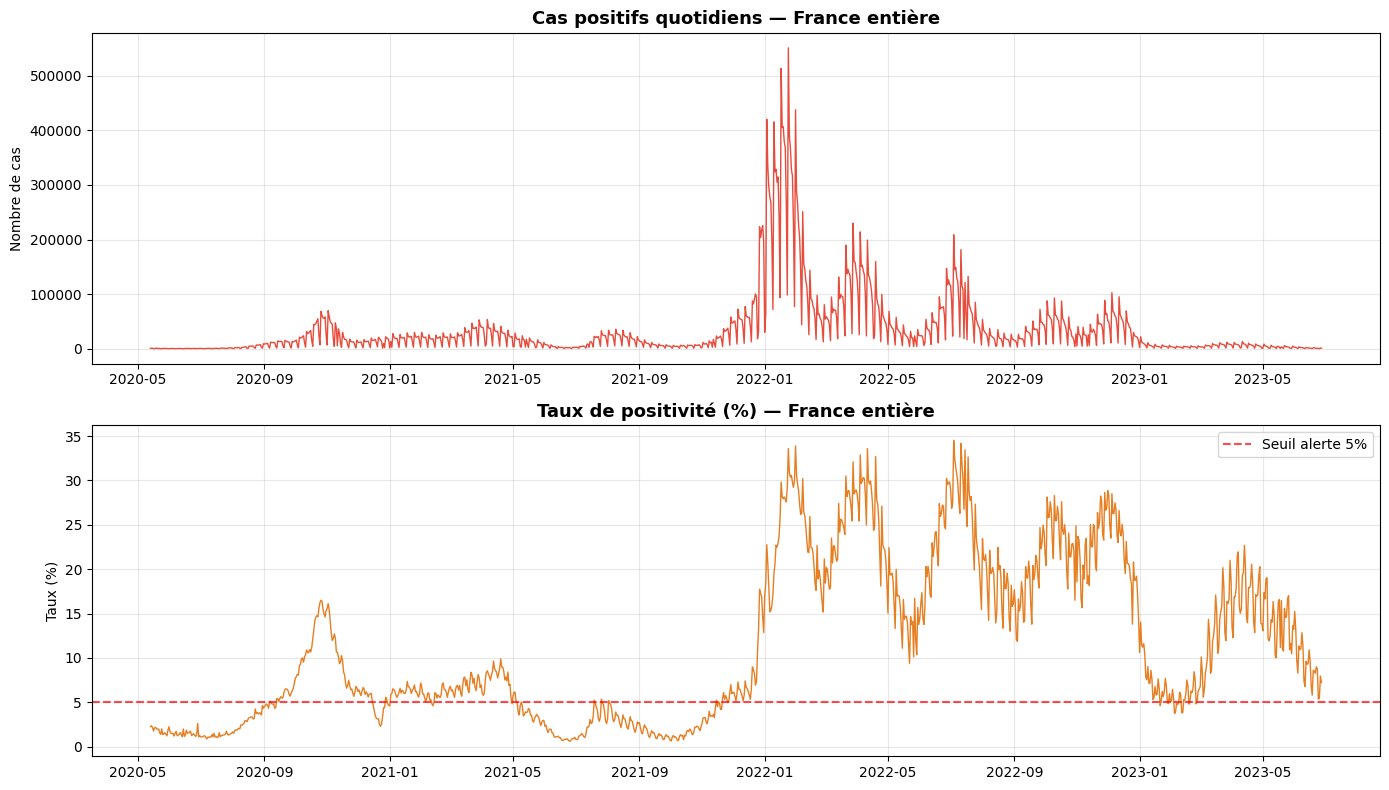


Graphique sauvegardé dans assets/


In [60]:
# Correction des types
df_tests = pd.read_csv(
    chemin_tests,
    sep=';',
    decimal=',',
    low_memory=False
)

# Vérification que les types sont corrects
print("Types après correction :")
for col in ['P', 'T', 'Tp', 'pop']:
    print(f"   - {col} : {df_tests[col].dtype}")

# FILTRE
# cl_age90 == 0 : "tous âges confondus"
# sans ce filtre, on compterait chaque cas plusieurs fois (une fois par tranche d'âge)
df_tests = df_tests[df_tests['cl_age90'] == 0].copy()
print(f"\nLignes après filtre tous âges : {len(df_tests):,}")

# Conversion date
df_tests['jour'] = pd.to_datetime(df_tests['jour'])

# Agrégation Nationale
df_national = df_tests.groupby('jour').agg(
    P=('P', 'sum'),
    T=('T', 'sum')
).reset_index()

# Calcul taux de positivité
df_national['taux_positivite'] = (df_national['P'] / df_national['T'] * 100).round(2)

print(f"\nPériode couverte : {df_national['jour'].min().date()} → {df_national['jour'].max().date()}")
print(f"Nombre de jours : {len(df_national)}")
print(f"\nAperçu :")
print(df_national.head(5).to_string())

# Visualisation
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

axes[0].plot(df_national['jour'], df_national['P'], color='#e74c3c', linewidth=1)
axes[0].set_title('Cas positifs quotidiens — France entière', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Nombre de cas')
axes[0].grid(True, alpha=0.3)

axes[1].plot(df_national['jour'], df_national['taux_positivite'], color='#e67e22', linewidth=1)
axes[1].axhline(y=5, color='red', linestyle='--', alpha=0.7, label='Seuil alerte 5%')
axes[1].set_title('Taux de positivité (%) — France entière', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Taux (%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PROJECT_ROOT / "assets" / "exploration_nationale.png", dpi=150, bbox_inches='tight')
plt.show()
print("\nGraphique sauvegardé dans assets/")

In [61]:
# Chargement hospitalisations
df_hosp = pd.read_csv(chemins["hospitalisations"], sep=';', decimal=',', low_memory=False)

print("DATASET HOSPITALISATIONS")
print("=" * 50)
print(f"Dimensions : {df_hosp.shape[0]:,} lignes × {df_hosp.shape[1]} colonnes")
print(f"\nColonnes :")
for col in df_hosp.columns:
    print(f"   - {col} ({df_hosp[col].dtype})")
print(f"\nAperçu :")
print(df_hosp.head(5).to_string())

DATASET HOSPITALISATIONS
Dimensions : 338,245 lignes × 10 colonnes

Colonnes :
   - dep (object)
   - sexe (int64)
   - jour (object)
   - hosp (int64)
   - rea (int64)
   - HospConv (float64)
   - SSR_USLD (float64)
   - autres (float64)
   - rad (int64)
   - dc (int64)

Aperçu :
  dep  sexe        jour  hosp  rea  HospConv  SSR_USLD  autres  rad  dc
0  01     0  2020-03-18     2    0       NaN       NaN     NaN    1   0
1  01     1  2020-03-18     1    0       NaN       NaN     NaN    1   0
2  01     2  2020-03-18     1    0       NaN       NaN     NaN    0   0
3  02     0  2020-03-18    41   10       NaN       NaN     NaN   18  11
4  02     1  2020-03-18    19    4       NaN       NaN     NaN   11   6


In [62]:
# Chargement vaccination
df_vacc = pd.read_csv(chemins["vaccination"], sep=';', decimal=',', low_memory=False)

print("DATASET VACCINATION")
print("=" * 50)
print(f"Dimensions : {df_vacc.shape[0]:,} lignes × {df_vacc.shape[1]} colonnes")
print(f"\nColonnes :")
for col in df_vacc.columns:
    print(f"   - {col} ({df_vacc[col].dtype})")
print(f"\nAperçu :")
print(df_vacc.head(5).to_string())

DATASET VACCINATION
Dimensions : 1,430,670 lignes × 21 colonnes

Colonnes :
   - dep (object)
   - clage_vacsi (int64)
   - jour (object)
   - n_dose1 (int64)
   - n_complet (int64)
   - n_rappel (int64)
   - n_2_rappel (int64)
   - n_rappel_biv (int64)
   - n_3_rappel (int64)
   - n_cum_dose1 (int64)
   - n_cum_complet (int64)
   - n_cum_rappel (int64)
   - n_cum_2_rappel (int64)
   - n_cum_rappel_biv (int64)
   - n_cum_3_rappel (int64)
   - couv_dose1 (object)
   - couv_complet (object)
   - couv_rappel (object)
   - couv_2_rappel (object)
   - couv_rappel_biv (object)
   - couv_3_rappel (object)

Aperçu :
  dep  clage_vacsi        jour  n_dose1  n_complet  n_rappel  n_2_rappel  n_rappel_biv  n_3_rappel  n_cum_dose1  n_cum_complet  n_cum_rappel  n_cum_2_rappel  n_cum_rappel_biv  n_cum_3_rappel couv_dose1 couv_complet couv_rappel couv_2_rappel couv_rappel_biv couv_3_rappel
0  01            4  2020-12-27        0          0         0           0             0           0            0  